## Objectives
This notebook is created to check how to deal with visual odometry relative pose to fuse with IMU data in inertial coordinate system.

In [2]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import Image

sys.path.append('/app/src')
from src.internal.extended_common import (
    CoordinateFrame,
    Pose, State,
    ExtendedConfig
)
from src.internal.dataset import OXTS_GPSDataReader
from src.common.datatypes import State, Pose
from src.utils.geometric_transformer import GeometryTransformer, TransformationField

warnings.filterwarnings("ignore")

In [3]:
config = ExtendedConfig("/app/configs/kitti_config.yaml")
transformer = GeometryTransformer(hardware_config=config.hardware)

In [4]:
variant = '09'

In [5]:
vo_relative_pose = pd.read_csv("/app/data/KITTI/vo_pose_estimates/2011_09_30/0033/data.csv", names=[str(i) for i in range(16)])\
    .values.reshape(-1, 4, 4)[:, :3, :]

ground_truth_path = os.path.join(f"/app/data/KITTI/ground_truth/{variant}.txt")
ground_truth = pd.read_csv(ground_truth_path, sep=' ', header=None, skiprows=1).values
ground_truth = ground_truth.reshape(-1, 3, 4)

In [6]:
print(f"gt pose shape: {ground_truth.shape}, vo pose shape: {vo_relative_pose.shape}")

gt pose shape: (1590, 3, 4), vo pose shape: (1593, 3, 4)


In [7]:
vo_abs_pose = []
vo_pose = np.eye(4)
vo_pose[:3, :3] = ground_truth[0, :3, :3]
vo_pose[:3, 3] = ground_truth[0, :3, 3]

for i in range(vo_relative_pose.shape[0]):
    rel = np.eye(4)
    rel[:3, :] = vo_relative_pose[i].copy()
    vo_pose = vo_pose @ rel
    vo_abs_pose.append(vo_pose)
    
vo_abs_pose = np.array(vo_abs_pose)

In [8]:
vo_abs_pose.shape

(1593, 4, 4)

In [9]:
gt_pos = ground_truth[:, :3, 3]
vo_pos = vo_abs_pose[:, :3, 3]

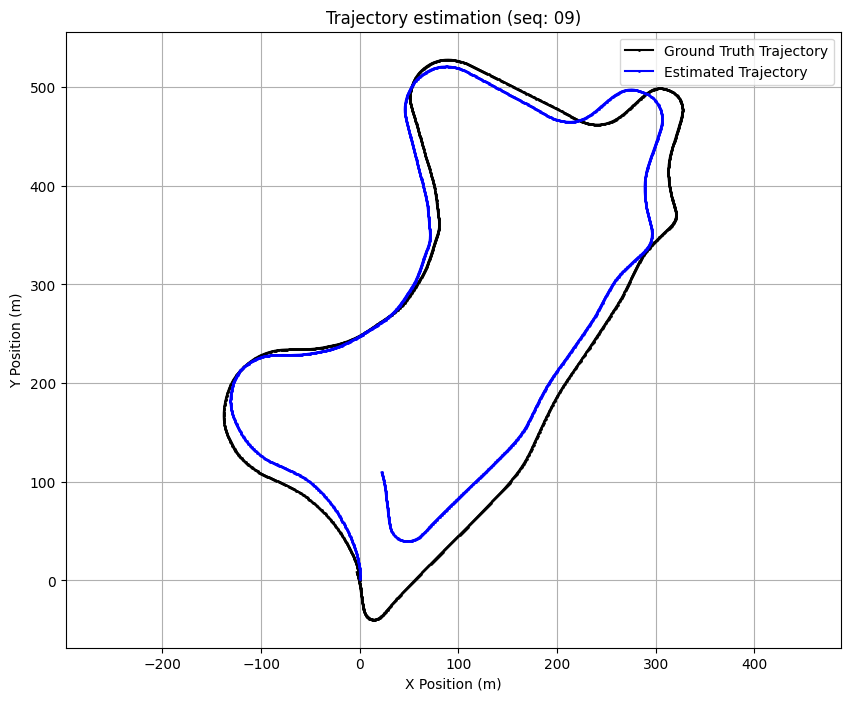

In [10]:
plt.figure(figsize=(10, 8))
px, py, pz = gt_pos.T
plt.plot(px, pz, marker='o', markersize=1, label='Ground Truth Trajectory', color='black')
px, py, pz = vo_pos.T
plt.plot(px, pz, marker='o', markersize=1, label='Estimated Trajectory', color='blue')
plt.title(f'Trajectory estimation (seq: {variant})')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.grid()
plt.legend()

In [11]:
state = State(
    p=np.zeros(3).reshape(-1, 1),
    v=np.zeros(3).reshape(-1, 1),
    q=np.array([1., 0., 0., 0.]).reshape(-1, 1),
    b_a=np.zeros(3).reshape(-1, 1),
    b_w=np.zeros(3).reshape(-1, 1),
)

oxts = OXTS_GPSDataReader(
    root_path="/app/data/KITTI",
    date="2011_09_30",
    drive="0033"
)

In [13]:
gps_inertial = []
for data in oxts:
    _gps = np.array([data.lon, data.lat, data.alt])
    value = transformer.transform(fields=TransformationField(
                state=state,
                value=_gps,
                coord_from=CoordinateFrame.GPS,
                coord_to=CoordinateFrame.INERTIAL))
    gps_inertial.append(value.flatten())

gps_inertial = np.array(gps_inertial)
print(f"Shape of OXTS GPS to Inertial transformation: {gps_inertial.shape}")

Shape of OXTS GPS to Inertial transformation: (1594, 3)


In [14]:
gps_inertial2 = []
for _gps in ground_truth:
    _R = _gps[:3, :3]
    _t = _gps[:3, 3].flatten()
    _q = State.get_quaternion_from_rotation_matrix(_R).flatten()
    _gps = np.hstack([_t, _q])
    value = transformer.transform(fields=TransformationField(
                state=state,
                value=_gps,
                coord_from=CoordinateFrame.STEREO_LEFT,
                coord_to=CoordinateFrame.INERTIAL))
    
    _t = value[:3].flatten()
    _q = value[3:].flatten()
    _R = State.get_rotation_matrix_from_quaternion_vector(_q)
    _pose = Pose(R=_R, t=_t).matrix(pose_only=True)
    gps_inertial2.append(_pose)

gps_inertial2 = np.array(gps_inertial2)

print(f"Shape of GPS to Inertial transformation (from ground truth): {gps_inertial2.shape}")

Shape of GPS to Inertial transformation (from ground truth): (1590, 3, 4)


In [15]:
vo_in_inertial = []
for _vo_pps in vo_pos:
    value = transformer.transform(fields=TransformationField(
                state=state,
                value=_vo_pps,
                coord_from=CoordinateFrame.STEREO_LEFT,
                coord_to=CoordinateFrame.INERTIAL))
    vo_in_inertial.append(value.flatten())

vo_in_inertial = np.array(vo_in_inertial)

print(f"Shape of VO to Inertial transformation: {vo_in_inertial.shape}")

Shape of VO to Inertial transformation: (1593, 3)


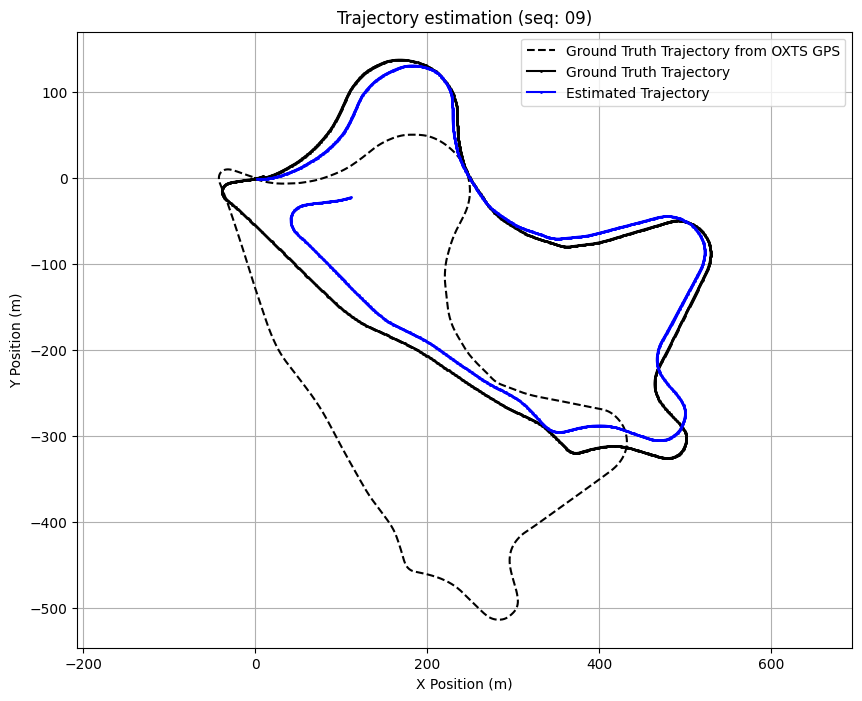

In [26]:
plt.figure(figsize=(10, 8))
px, py, pz = gps_inertial.T
plt.plot(px, py, linestyle='dashed', markersize=1, label='Ground Truth Trajectory from OXTS GPS', color='black')
px, py, pz = gps_inertial2[:, :3, 3].T
plt.plot(px, py, marker='o', markersize=1, label='Ground Truth Trajectory', color='black')
px, py, pz = vo_in_inertial.T
plt.plot(px, py, marker='o', markersize=1, label='Estimated Trajectory', color='blue')
plt.title(f'Trajectory estimation (seq: {variant})')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.grid()
plt.legend()

### Handle relative pose

Check if trajectory is valid when vo pose is computed after transforming relative pose to the inertial frame

In [84]:
# Transformation matrix that transforms a vector in camera frame to the inertial frame
T_from_cam_to_imu = transformer._transformer.T_from_cam_to_imu.copy()
T_from_cam_to_imu

# Transformation matrix that rotates 90 degree in z-axis
Rz_90 = np.array([
    [0, -1, 0],
    [1, 0, 0],
    [0, 0, 1]
])
T_Rz_90 = np.eye(4)
T_Rz_90[:3, :3] = Rz_90

In [85]:
pose1 = np.eye(4)
pose1[:3, 3] = np.array([1, 1, 1])
pose2 = np.eye(4)
pose2[:3, 3] = np.array([3, 0, 0])
angle_rad = np.deg2rad(45)
R_45 = np.array([
    [np.cos(angle_rad), -np.sin(angle_rad), 0],
    [np.sin(angle_rad),  np.cos(angle_rad), 0],
    [0, 0, 1]
])
pose2[:3, :3] = R_45

In [86]:
delta_pose = np.linalg.inv(pose1) @ pose2
delta_pose

array([[ 0.71, -0.71,  0.  ,  2.  ],
       [ 0.71,  0.71,  0.  , -1.  ],
       [ 0.  ,  0.  ,  1.  , -1.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [87]:
pose1_inertial = T_Rz_90 @ pose1 @ np.linalg.inv(T_Rz_90)
pose2_inertial = T_Rz_90 @ pose2 @ np.linalg.inv(T_Rz_90)

delta_pose_inertial = np.linalg.inv(pose1_inertial) @ pose2_inertial
np.round(delta_pose_inertial, 3)

array([[ 0.71, -0.71,  0.  ,  1.  ],
       [ 0.71,  0.71,  0.  ,  2.  ],
       [ 0.  ,  0.  ,  1.  , -1.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]])

In [88]:
print(f"Computed pose2: \n{pose1 @ delta_pose}")
print(f"Original pose2: \n{pose2}")

Computed pose2: 
[[ 0.71 -0.71  0.    3.  ]
 [ 0.71  0.71  0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
Original pose2: 
[[ 0.71 -0.71  0.    3.  ]
 [ 0.71  0.71  0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]


In [89]:
print(f"Computed pose2: \n{np.round(pose1_inertial @ delta_pose, 2)}")
print(f"Original pose2: \n{np.round(pose2_inertial, 2)}")

Computed pose2: 
[[ 0.71 -0.71  0.    1.  ]
 [ 0.71  0.71  0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
Original pose2: 
[[ 0.71 -0.71  0.    0.  ]
 [ 0.71  0.71  0.    3.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]


In [90]:
delta_pose_inertial_correct = T_Rz_90 @ delta_pose @ np.linalg.inv(T_Rz_90)

print(f"Computed pose2: \n{np.round(pose1_inertial @ delta_pose_inertial_correct, 2)}")
print(f"Original pose2: \n{np.round(pose2_inertial, 2)}")

Computed pose2: 
[[ 0.71 -0.71  0.    0.  ]
 [ 0.71  0.71  0.    3.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
Original pose2: 
[[ 0.71 -0.71  0.    0.  ]
 [ 0.71  0.71  0.    3.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]


In [91]:
np.set_printoptions(precision=2, suppress=True)

# Step 1: Define 90-degree rotation about Z axis
Rz_90 = np.array([
    [0, -1, 0],
    [1,  0, 0],
    [0,  0, 1]
])
T_Rz_90 = np.eye(4)
T_Rz_90[:3, :3] = Rz_90

T_Rz_90_inv = np.linalg.inv(T_Rz_90)

# Step 2: Define pose1 and pose2 in body frame
pose1 = np.eye(4)
pose1[:3, 3] = np.array([1, 1, 1])

pose2 = np.eye(4)
# Add rotation in pose2 to highlight the importance of transforming delta pose
angle_rad = np.deg2rad(45)
R_45 = np.array([
    [np.cos(angle_rad), -np.sin(angle_rad), 0],
    [np.sin(angle_rad),  np.cos(angle_rad), 0],
    [0, 0, 1]
])
pose2[:3, :3] = R_45
pose2[:3, 3] = np.array([3, 0, 0])

# Step 3: Compute delta pose in body frame
delta_pose_body = np.linalg.inv(pose1) @ pose2

# Step 4: Transform both poses to inertial frame
pose1_inertial = T_Rz_90 @ pose1 @ T_Rz_90_inv
pose2_inertial = T_Rz_90 @ pose2 @ T_Rz_90_inv

# Step 5: CORRECT method: transform delta pose to inertial frame, then apply it
delta_pose_inertial = T_Rz_90 @ delta_pose_body @ T_Rz_90_inv
pose2_inertial_from_delta = pose1_inertial @ delta_pose_inertial

# Step 6: INCORRECT method: apply body delta pose directly in inertial frame
pose2_inertial_wrong = pose1_inertial @ delta_pose_body

# Step 7: Compare results
print("=== Ground Truth pose2 in Inertial Frame ===")
print(np.round(pose2_inertial, 3))

print("\n=== pose2_inertial computed CORRECTLY from delta_pose_body ===")
print(np.round(pose2_inertial_from_delta, 3))

print("\n=== pose2_inertial computed INCORRECTLY (no frame transform) ===")
print(np.round(pose2_inertial_wrong, 3))

# Optional: check numerical error
error_correct = np.linalg.norm(pose2_inertial - pose2_inertial_from_delta)
error_wrong = np.linalg.norm(pose2_inertial - pose2_inertial_wrong)

print("\nError (correct method):", round(error_correct, 6))
print("Error (wrong method):", round(error_wrong, 6))

=== Ground Truth pose2 in Inertial Frame ===
[[ 0.71 -0.71  0.    0.  ]
 [ 0.71  0.71  0.    3.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]

=== pose2_inertial computed CORRECTLY from delta_pose_body ===
[[ 0.71 -0.71  0.    0.  ]
 [ 0.71  0.71  0.    3.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]

=== pose2_inertial computed INCORRECTLY (no frame transform) ===
[[ 0.71 -0.71  0.    1.  ]
 [ 0.71  0.71  0.    0.  ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]

Error (correct method): 0.0
Error (wrong method): 3.162278


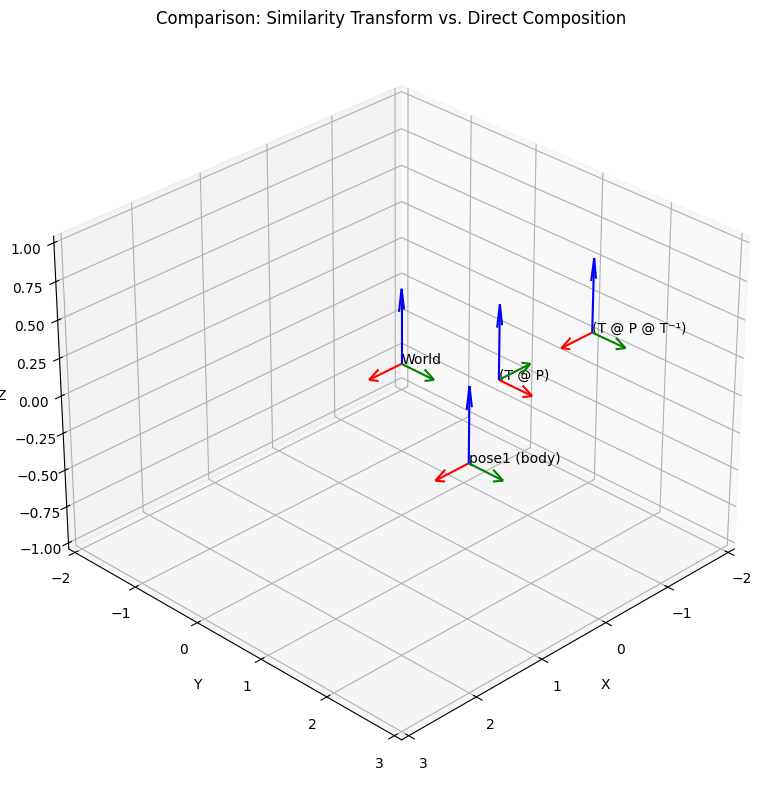

In [98]:
def draw_frame(ax, T, name, color):
    origin = T[:3, 3]
    R = T[:3, :3]
    length = 0.5

    # Draw x, y, z axes
    ax.quiver(*origin, *R[:, 0], length=length, color=color[0])  # x-axis
    ax.quiver(*origin, *R[:, 1], length=length, color=color[1])  # y-axis
    ax.quiver(*origin, *R[:, 2], length=length, color=color[2])  # z-axis
    ax.text(*origin, name, color='black')

# Define base frame (world)
T_world = np.eye(4)

# Define 90 degree rotation around Z axis (ENU -> body)
Rz_90 = np.array([
    [0, -1, 0],
    [1,  0, 0],
    [0,  0, 1]
])
T_Rz_90 = np.eye(4)
T_Rz_90[:3, :3] = Rz_90
T_Rz_90_inv = np.linalg.inv(T_Rz_90)

# Define pose1 (in body frame)
pose1 = np.eye(4)
pose1[:3, 3] = [1, 2, 0]  # translate in X and Y

# Compute transformed versions
similarity_transformed = T_Rz_90 @ pose1 @ T_Rz_90_inv  # coordinate frame change

T_Rz_90 = np.eye(4)
T_Rz_90[:3, 3] = [1.5, 0, 0]
T_Rz_90[:3, :3] = Rz_90
T_Rz_90_inv = np.linalg.inv(T_Rz_90)
direct_composed = T_Rz_90 @ pose1                      # motion composition

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim([-2, 3])
ax.set_ylim([-2, 3])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=30, azim=45)

# Draw frames
draw_frame(ax, T_world, "World", ['r', 'g', 'b'])
draw_frame(ax, pose1, "pose1 (body)", ['r', 'g', 'b'])
draw_frame(ax, similarity_transformed, "(T @ P @ T⁻¹)", ['r', 'g', 'b'])
draw_frame(ax, direct_composed, "(T @ P)", ['r', 'g', 'b'])

plt.title("Comparison: Similarity Transform vs. Direct Composition")
plt.tight_layout()
plt.show()

In [102]:
vo_relative_pose.shape

(1593, 3, 4)

In [115]:
_vo_abs_pose_list = []
_vo_abs_pose = np.eye(4)
_vo_abs_pose[:3, 3] = gps_inertial[0]

for _rel in vo_relative_pose:
    rel = np.eye(4)
    rel[:3, :] = _rel.copy()
    value = T_from_cam_to_imu @ rel @ np.linalg.inv(T_from_cam_to_imu)
    _vo_abs_pose = _vo_abs_pose @ value

    _vo_abs_pose_list.append(_vo_abs_pose[:3, :])

_vo_abs_pose_list = np.array(_vo_abs_pose_list)


In [ ]:
_vo_abs_pose_list.shape

(1593, 3)

In [133]:
vo_pose_i = []
for v in vo_pos:
    pose = np.eye(4)
    pose[:3, 3] = v
    # pose = np.array([v[0], v[1], v[2], 1.0])
    value = T_from_cam_to_imu @ pose @ np.linalg.inv(T_from_cam_to_imu)
    vo_pose_i.append(value[:3, 3])

vo_pose_i = np.array(vo_pose_i)
print(f"Shape of vo_pose_i: {vo_pose_i.shape}")

Shape of vo_pose_i: (1593, 3)


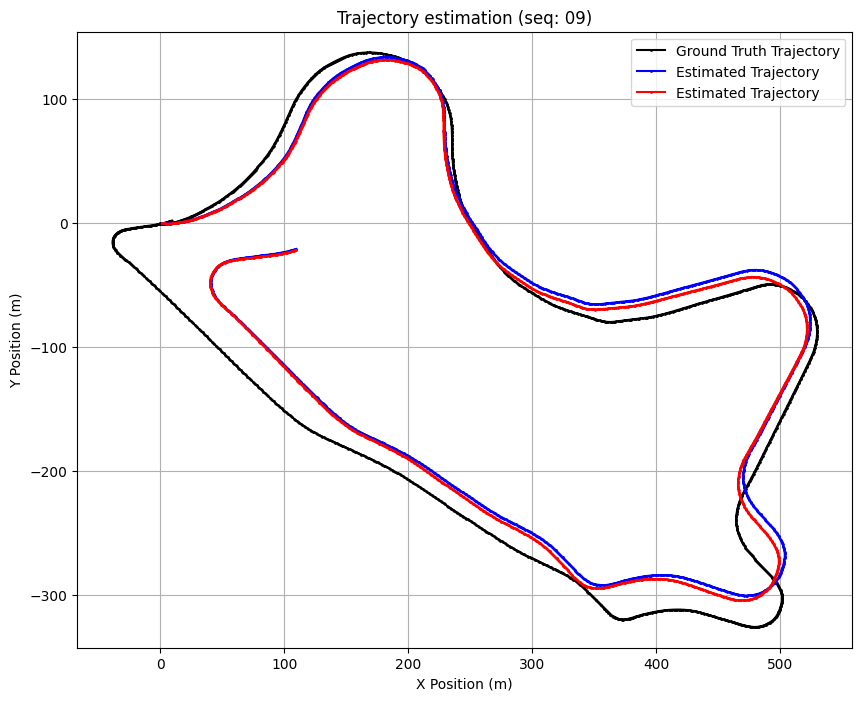

In [ ]:
plt.figure(figsize=(10, 8))
px, py, pz = gps_inertial2[:, :3, 3].T
plt.plot(px, py, marker='o', markersize=1, label='Ground Truth Trajectory', color='black')
px, py, pz = _vo_abs_pose_list[:, :3, 3].T
plt.plot(px, py, marker='o', markersize=1, label='Estimated Trajectory', color='blue')
# px, py, pz = vo_pose_i.T
# plt.plot(px, py, marker='o', markersize=1, label='Estimated Trajectory', color='red')
plt.title(f'Trajectory estimation (seq: {variant})')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.axis('equal')
plt.grid()
plt.legend()